In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from spellchecker import SpellChecker
from typing import Optional

In [2]:
from typing import List, Dict
from collections import defaultdict
from enum import Enum

from account import Account  # Assuming Account class is defined in account.py
from transaction import Transaction  # Assuming Transaction class is defined in transactions.py
from ei_finance import EiFinance

def add_expense2csv(expenses: List[Transaction], filename: str):
    # Read existing data if the file exists
    try:
        existing_df = pd.read_csv(filename)
        # Append new expenses to existing data
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
        combined_df = pd.concat([existing_df, new_df], ignore_index=True)
    except FileNotFoundError:
        # If file does not exist, just use new expenses
        combined_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    combined_df.to_csv(filename, index=False)

def save_expense2csv(expenses: List[Transaction], filename: str):
    # Read existing data if the file exists
    try:
        # Append new expenses to existing data
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    except FileNotFoundError:
        # If file does not exist, just use new expenses
        new_df = pd.DataFrame([expense.to_dict() for expense in expenses])
    new_df.to_csv(filename, index=False)

def add_expense2expenses(expenses: List[Transaction], existing_expenses: List[Transaction]) -> List[Transaction]:
    for expense in expenses:
        # Check if the expense already exists in the existing expenses
        if not any(existing_expense.id == expense.id for existing_expense in existing_expenses):
            existing_expenses.append(expense)
        else:
            print(f"Transaction with ID {expense.id} already exists. Skipping.")
    return existing_expenses

def read_expenses_from_csv(csv) -> List[Transaction]:
    df = pd.read_csv(csv)

#    for idx, row in df.iterrows():
        # You can access each row as a Series, e.g. row['name'], row['amount'], etc.
#        print(row)
    expenses = []
    for _, row in df.iterrows():
        expense = Transaction(
            name=row.get('name'),
            date=row.get('date'),
            currency=row.get('currency'),
            amount=row.get('amount'),
            account=row.get('account'),
            description=row.get('description'),
            category=row.get('category'),
            tags=row.get('tags').split(',') if isinstance(row.get('tags'), str) else [],
            recurring=row.get('recurring') in [True, 'True', 'true', 'yes', 'Yes'],
            frequency=row.get('frequency'),
            inout=row.get('inout'),
            id=row.get('id') if pd.notnull(row.get('id')) else None
        )
        expenses.append(expense)
    return expenses

def get_expenses_cost(expenses: List[Transaction]) -> float:
    """Calculate the total cost of all expenses."""
    total_cost = sum(expense.amount for expense in expenses if expense.inout == 'out')
    return total_cost
def get_expenses_income(expenses: List[Transaction]) -> float:
    """Calculate the total income from all expenses."""
    total_income = sum(expense.amount for expense in expenses if expense.inout == 'in')
    return total_income
def get_expenses_balance(expenses: List[Transaction]) -> float:
    """Calculate the balance from all expenses."""
    total_cost = get_expenses_cost(expenses)
    total_income = get_expenses_income(expenses)
    return total_income - total_cost

def draw_piechart(expenses: List[Transaction], by: str = 'category', title: Optional[str] = None):
    """
    Draw a pie chart of expenses grouped by a specified attribute.
    Args:
        expenses: List of Transaction objects.
        by: Attribute to group by ('category', 'tags', or 'account').
        title: Title for the chart. If None, a default will be used.
    """
    title = title + " " + by.capitalize() if title else None

    data = defaultdict(float)
    if by == 'tags':
        for expense in expenses:
            if expense.tags:
                for tag in expense.tags:
                    if tag:
                        data[tag.strip()] += expense.amount
    elif by == 'category':
        for expense in expenses:
            key = expense.category if expense.category else 'Uncategorized'
            data[key] += expense.amount
    elif by == 'account':
        for expense in expenses:
            key = expense.account.strip() if expense.account else 'Unknown Bank'
            data[key] += expense.amount
    else:
        for expense in expenses:
            key = getattr(expense, by, None)
            if key:
                data[key] += expense.amount

    if not data:
        print(f"No data to plot for '{by}'.")
        return

    if title is None:
        title = f"Expenses by {by.capitalize()}"

    plt.figure(figsize=(10, 6))
    plt.pie(data.values(), labels=[str(k) for k in data.keys()], autopct='%1.1f%%', startangle=140)
    plt.title(title)
    plt.axis('equal')
    plt.show()

def get_expenses_banks(expenses: List[Transaction], account: str) -> List[Transaction]:
    """Print the unique banks from the expenses."""
    return [expense for expense in expenses if expense.account == account]


In [3]:

csv = 'data/transactions.csv'
csv2 = 'data/accounts.csv'
ei_finance = EiFinance(csv, csv2)

new_expense = Transaction(
    name='Groceries',
    date='2023-01-03',
    currency='USD',
    amount=150.00,
    description='Weekly grocery shopping',
    tags=['groceries', 'food'],
    recurring=False,
    frequency=None,
    inout='out'
)

new_expense.print()
ei_finance.expenses = add_expense2expenses([new_expense], ei_finance.expenses)
save_expense2csv(ei_finance.expenses, csv)

print("Unique Tags:", ei_finance.tags)


Name: Groceries, Date: 2023-01-03, Currency: USD, Amount: 150.0, Bank: None, Description: Weekly grocery shopping, Category: None, Tags: groceries, food, Recurring: False, Frequency: None, In/Out: out, ID: Groceries_2023-01-03_150.0_USD
Transaction with ID Groceries_2023-01-03_150.0_USD already exists. Skipping.
Unique Tags: ['food', 'groceries', 'salary']


In [4]:
bank_expenses = get_expenses_banks(ei_finance.expenses, 'Bank of America')
for expense in bank_expenses:
    expense.print()

#draw_piechart(ei_finance.expenses, 'account', 'Expenses by')
#draw_piechart(ei_finance.expenses, 'category', 'Expenses by')

ei_finance.update_accounts()
print(ei_finance.accounts[0].balance)

#ei_finance.plot_accounts('USD')
for expense in ei_finance.get_incomplete_expenses('account'):
    print(f"Incomplete Transaction: {expense.name} on {expense.date} with amount {expense.amount} in {expense.inout}")
    expense.update({'account': 'jorge'})

for expense in ei_finance.get_incomplete_expenses('category'):
    print(f"Incomplete Transaction: {expense.name} on {expense.date} with amount {expense.amount} in {expense.inout}")
    expense.update({'category': 'small'})

save_expense2csv(ei_finance.expenses, ei_finance.filenameExpenses)

Name: Groceries, Date: 2023-01-20, Currency: USD, Amount: 150.0, Bank: Bank of America, Description: Weekly grocery shopping, Category: Category.MEDIUM, Tags: groceries, food, Recurring: False, Frequency: nan, In/Out: out, ID: nan
Name: Groceries, Date: 2023-10-02, Currency: USD, Amount: 150.0, Bank: Bank of America, Description: Weekly grocery shopping, Category: Category.MEDIUM, Tags: groceries, food, Recurring: False, Frequency: nan, In/Out: out, ID: Groceries_2023-10-02_150.0_USD
Bank A
2025-06-24 00:00:00
Bank of America
2025-06-24 00:00:00
{'2023-01-01': 0, '2023-01-02': 0, '2023-01-03': 0, '2023-01-04': 0, '2023-01-05': 0, '2023-01-06': 0, '2023-01-07': 0, '2023-01-08': 0, '2023-01-09': 0, '2023-01-10': 0, '2023-01-11': 0, '2023-01-12': 0, '2023-01-13': 0, '2023-01-14': 0, '2023-01-15': 0, '2023-01-16': 0, '2023-01-17': 0, '2023-01-18': 0, '2023-01-19': 0, '2023-01-20': 0, '2023-01-21': 0, '2023-01-22': 0, '2023-01-23': 0, '2023-01-24': 0, '2023-01-25': 0, '2023-01-26': 0, '2023

Balance Dictionary Example 1: {'2023-10-01': 1000.0, '2023-10-02': 1000.0, '2023-10-03': 1000.0, '2023-10-04': 1000.0, '2023-10-05': 1000.0, '2023-10-06': 1000.0, '2023-10-07': 1000.0, '2023-10-08': 1000.0, '2023-10-09': 1000.0, '2023-10-10': 900.0, '2023-10-11': 900.0, '2023-10-12': 900.0, '2023-10-13': 900.0, '2023-10-14': 900.0, '2023-10-15': 700.0, '2023-10-16': 700.0, '2023-10-17': 700.0, '2023-10-18': 700.0, '2023-10-19': 700.0, '2023-10-20': 550.0, '2023-10-21': 550.0, '2023-10-22': 550.0, '2023-10-23': 550.0, '2023-10-24': 550.0, '2023-10-25': 550.0, '2023-10-26': 550.0, '2023-10-27': 550.0, '2023-10-28': 550.0, '2023-10-29': 550.0, '2023-10-30': 550.0, '2023-10-31': 550.0}
Balance Dictionary Example 2: {'2023-10-01': 2000.0, '2023-10-02': 2000.0, '2023-10-03': 2000.0, '2023-10-04': 2000.0, '2023-10-05': 2000.0, '2023-10-06': 2000.0, '2023-10-07': 2000.0, '2023-10-08': 2000.0, '2023-10-09': 2000.0, '2023-10-10': 2000.0, '2023-10-11': 2000.0, '2023-10-12': 2000.0, '2023-10-13': 

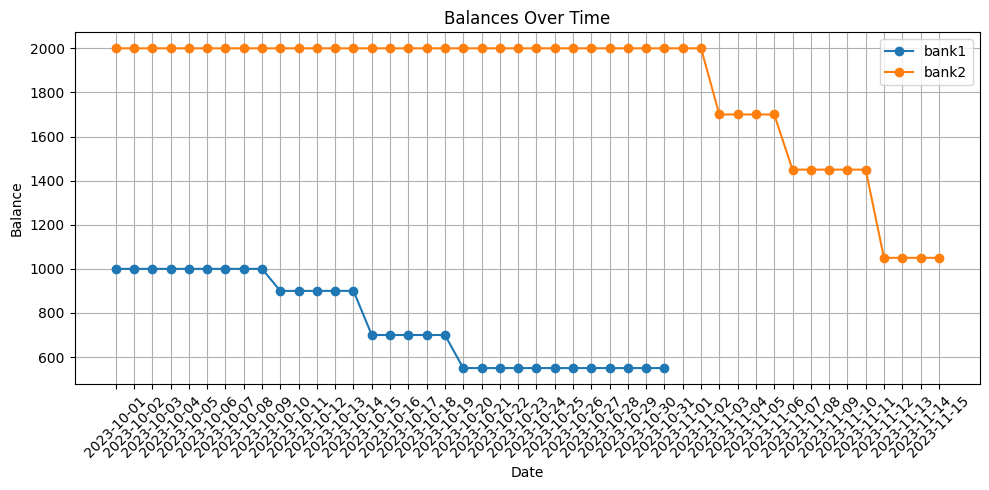

In [5]:
## THIS IS A GOOD LOGIC TO IMPLEMENT TO CALCULATE THE BALANCE OVER TIME

from datetime import datetime, timedelta
import mplcursors

class BalanceOverTime:
    def __init__(self, start_date, initial_balance, end_date, expenses, name):
        self.start_date = start_date
        self.initial_balance = initial_balance
        self.end_date = end_date
        self.expenses = expenses
        self.balance_dict = self.calculate_balance()
        self.name = name

    @staticmethod
    def diff(start_date, end_date):
        start = datetime.strptime(start_date, "%Y-%m-%d")
        end = datetime.strptime(end_date, "%Y-%m-%d")
        delta = (end - start).days
        return [(start + timedelta(days=i)).strftime("%Y-%m-%d") for i in range(delta + 1)]

    def calculate_balance(self):
        balance_dict = {}
        balance_dict[self.start_date] = self.initial_balance
        for date in self.diff(self.start_date, self.end_date):
            if date == self.start_date:
                continue
            prev_date = (datetime.strptime(date, "%Y-%m-%d") - timedelta(days=1)).strftime("%Y-%m-%d")
            if date in self.expenses:
                balance_dict[date] = balance_dict[prev_date] - self.expenses[date]
            else:
                balance_dict[date] = balance_dict[prev_date]
        return balance_dict

    def plot_balance(self):
        all_dates = self.diff(self.start_date, self.end_date)
        dates = [d for d in all_dates if d in self.balance_dict]
        if not dates:
            raise ValueError("No balance data available in the given interval.")
        balances = [self.balance_dict[d] for d in dates]

        plt.figure(figsize=(10, 5))
        plt.plot(dates, balances, marker='o')
        plt.title('Balance Over Time')
        plt.xlabel('Date')
        plt.ylabel('Balance')
        plt.xticks(rotation=45)
        plt.grid()
        plt.tight_layout()
        plt.show()

# Example 1
bot1 = BalanceOverTime(
    start_date='2023-10-01',
    initial_balance=1000.0,
    end_date='2023-10-31',
    expenses={'2023-10-10': 100.0, '2023-10-15': 200.0, '2023-10-20': 150.0},
    name='bank1'
)
print("Balance Dictionary Example 1:", bot1.balance_dict)
#bot1.plot_balance()

# Example 2
bot2 = BalanceOverTime(
    start_date='2023-10-01',
    initial_balance=2000.0,
    end_date='2023-11-15',
    expenses={'2023-11-03': 300.0, '2023-11-07': 250.0, '2023-11-12': 400.0},
    name='bank2'
)

print("Balance Dictionary Example 2:", bot2.balance_dict)
#bot2.plot_balance()

def plot_balances(balance_objs, start_date, end_date):
    """
    Plot multiple BalanceOverTime objects' balances on the same plot with legends.
    Each BalanceOverTime object should have a 'name' attribute.
    Adds interactive hover tooltips using mplcursors.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    lines = []
    for bot in balance_objs:
        all_dates = bot.diff(start_date, end_date)
        dates = [d for d in all_dates if d in bot.balance_dict]
        if not dates:
            continue
        balances = [bot.balance_dict[d] for d in dates]
        line, = plt.plot(dates, balances, marker='o', label=getattr(bot, 'name', 'Balance'))
        lines.append(line)

    plt.title('Balances Over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Add interactive hover tooltips
    cursor = mplcursors.cursor(lines, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        x, y = sel.target
        sel.annotation.set(text=f"Date: {dates[int(round(x))]}\nBalance: {y:.2f}",
                           bbox=dict(boxstyle="round", fc="yellow", alpha=0.7))

    plt.show()

plot_balances([bot1, bot2], '2023-10-01', '2023-11-15')



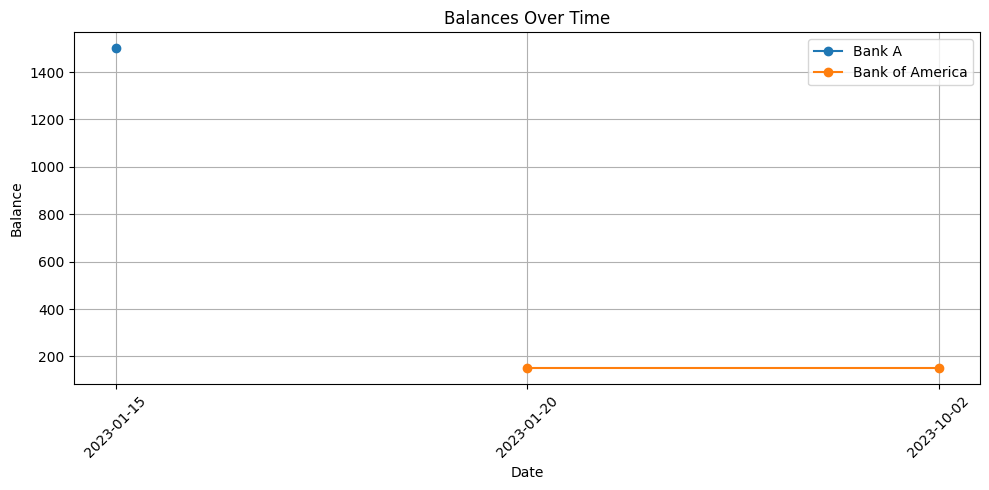

In [13]:
start_date = '2023-01-01'
end_date = '2023-11-15'

ei_finance.get_expenses_per_bank()
plt.figure(figsize=(10, 5))
lines = []
for account, expenses in ei_finance.expenses_per_bank.items():
    idx = next((i for i, acc in enumerate(ei_finance.accounts) if acc.name == account), None)
    if idx is not None:
        ei_finance.accounts[idx].calculate_balance(str(ei_finance.current_day.date()), expenses)
        all_dates = ei_finance.accounts[idx].diff(start_date, end_date)
        dates = [d for d in all_dates if d in expenses]
        if not dates:
            continue
        balances = [expenses[d] for d in dates]
        line, = plt.plot(dates, balances, marker='o', label=account)
        lines.append(line)
plt.title('Balances Over Time')
plt.xlabel('Date')
plt.ylabel('Balance')
plt.xticks(rotation=45)
plt.legend()
plt.grid()
plt.tight_layout()

def plot_balances(balance_objs, start_date, end_date):
    """
    Plot multiple BalanceOverTime objects' balances on the same plot with legends.
    Each BalanceOverTime object should have a 'name' attribute.
    Adds interactive hover tooltips using mplcursors.
    """
    import matplotlib.pyplot as plt

    plt.figure(figsize=(10, 5))
    lines = []
    for bot in balance_objs:
        all_dates = bot.diff(start_date, end_date)
        dates = [d for d in all_dates if d in bot.balance_dict]
        if not dates:
            continue
        balances = [bot.balance_dict[d] for d in dates]
        line, = plt.plot(dates, balances, marker='o', label=getattr(bot, 'name', 'Balance'))
        lines.append(line)

    plt.title('Balances Over Time')
    plt.xlabel('Date')
    plt.ylabel('Balance')
    plt.xticks(rotation=45)
    plt.legend()
    plt.grid()
    plt.tight_layout()

    # Add interactive hover tooltips
    cursor = mplcursors.cursor(lines, hover=True)
    @cursor.connect("add")
    def on_add(sel):
        x, y = sel.target
        sel.annotation.set(text=f"Date: {dates[int(round(x))]}\nBalance: {y:.2f}",
                           bbox=dict(boxstyle="round", fc="yellow", alpha=0.7))

    plt.show()
